# Analysing the MNIST dataset using Classification techniques

The MNIST database is a very large dataset of over 60000 handwritten digits each presented in a 28 x 28 pixel image. It has been used to train and test many machine learning techniques and many researcher have boasted "near human performance" on their algorithms.
This project is part of Kaggle's Digit recognizer competition, I will be using a variety of SciKit-learns classification models to try and achieve the highest possible accuracy.

## Visulizing the data

The data for this project can be downloaded [here](https://www.kaggle.com/c/digit-recognizer/data). The data is split up into test and train datasets with 28000 and 42000 digits in each. The test data will be revisited at the end for submission to Kaggle to get the final accuracy score.

Below I load the data and have diplayed a few digits as well as given a heat-map of the pixel activity

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import time

In [8]:
# Load data
data = pd.read_csv('train.csv')
train = data.drop('label', 1)

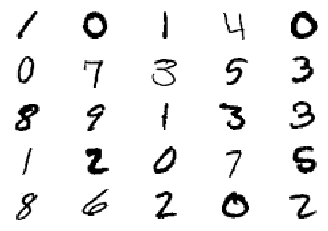

In [9]:
# Displaying some numbers and features
for i in range(25):
    plt.subplot(5,5,i + 1)
    img = train.iloc[i].values.reshape(28,28)
    plt.imshow(img, cmap = 'binary')
    plt.axis('off')


Text(0.5, 1.0, 'Pixel variance')

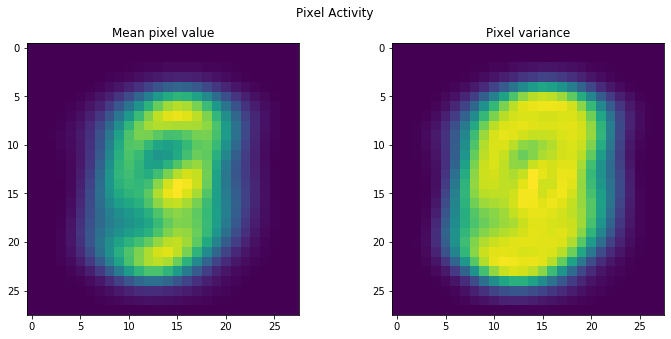

In [10]:
# Visulize pixel activity
heat_map = train.mean()
variance = train.var()
# plt.subplot(1,2,1, autoscalex_on = True)
# plt.imshow(heat_map.values.reshape(28,28))
# plt.subplot(1,2,2,autoscalex_on = True)
# plt.imshow(variance.values.reshape(28,28))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12,5))
fig.suptitle('Pixel Activity')
ax1.imshow(heat_map.values.reshape(28,28))
ax1.set_title('Mean pixel value')
ax2.imshow(variance.values.reshape(28,28))
ax2.set_title('Pixel variance')

## Random Forest

A Random forest is a collection of decision trees performed on subsets of the data, decision trees operate by recursively splitting the data along its most important feature untill all the data is best categorised. 
I'll be starting with this model as it does an good job of only using the features necessary, the plots above shows that many of the pixels have very little activity, decision trees will only consider the most active pixels to use. Hopefully it will give a good baseline accuracy to try and beat in the rest of the project.

In [11]:
# Import necessary functions
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

This function will used to fit and test the classifying models, below I use it to run an initial test on the Random Forest.

In [12]:
# classifier tester

def fit_score(classifier, data, labels, test_ratio = None, seed = None):
    data_train, data_test, labels_train, labels_test = train_test_split(data, labels, test_size = test_ratio, random_state = seed)
    
    classifier.fit(data_train, labels_train)
    pred = classifier.predict(data_test)
    
    return accuracy_score(labels_test, pred)

In [14]:
# Initial test 

clf = RandomForestClassifier()

fit_score(clf, train, data['label'])

C:\Users\Lang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.9356190476190476

Thats not bad at all, this was only using 10 trees in the forest however. I want to experiment to see if increasing the number of trees leads to a significant increase in accuracy. For the sake of time I'll only use the first 1000 digits the dataset:

In [15]:
# Varying the number of trees
trees = [1,2,5,10,20,50,100,200,300,500,750,1000]
trees_df = pd.DataFrame(index = trees, columns = ['Accuracy', 'Time'])
for i in trees:
    t0 = time()
    clf = RandomForestClassifier(i)
    accuracy = fit_score(clf, train.iloc[:1000], data['label'].iloc[:1000], seed = 0)
    trees_df.at[i,'Accuracy'] = accuracy
    trees_df.at[i, 'Time'] = time() - t0

print(trees_df)

     Accuracy       Time
1       0.488  0.0813079
2       0.572  0.0479007
5       0.704  0.0647795
10        0.8   0.103929
20      0.856   0.198435
50      0.888   0.476089
100     0.888    1.00006
200     0.912    1.88525
300       0.9    2.73153
500     0.904    4.58883
750     0.908    6.43359
1000    0.904    10.1616


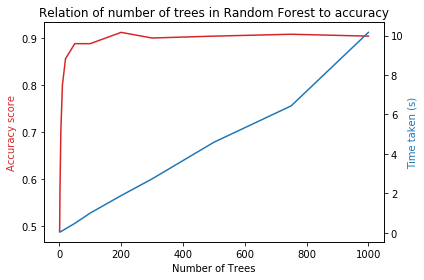

In [16]:
x = trees_df.index.values
fig, ax1 = plt.subplots()
plt.title('Relation of number of trees in Random Forest to accuracy')

color = 'tab:red'
ax1.set_xlabel('Number of Trees')
ax1.set_ylabel('Accuracy score', color=color)
ax1.plot(x, trees_df['Accuracy'], color=color)

ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('Time taken (s)', color=color)  
ax2.plot(x, trees_df['Time'], color=color)

fig.tight_layout()  
plt.show()

It appears that the accuracy plateaus at approximately 0.9 (this was lower than the intial run due to the smaller training dataset) whereas the time taken for the training increased linearly. 
I've decided to set the number of trees at 200, below I test the performance for the Random Forest on the full testing dataset.

In [17]:
t0 = time()
clf_RF = RandomForestClassifier(200)
accuracy = fit_score(clf_RF, train, data['label'])
print(f'RandomForestClassifier got and accuracy score of {accuracy} \nTime taken: {time() - t0} seconds')

RandomForestClassifier got and accuracy score of 0.9659047619047619 
Time taken: 92.14071464538574 seconds


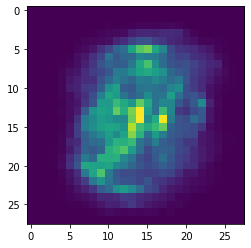

In [18]:
# Display the feature importances for the Random Forest Classifier
plt.imshow(clf.feature_importances_.reshape(28,28))

0.964 is pretty impressive for now. The feature importances of the model show that only some of the pixels were really used, it makes sense to do some feature reduction before trying out some of the other classifiers

## Principal Component Analysis

PCA is a dimensionality reduction technique that performs a linear mapping to data to a lower-dimensional space, but done in such a way that the variance of the data in the low-dimensional representation is maximized. 

In [19]:
# Import functions
from sklearn.decomposition import PCA

In [20]:
pca = PCA(n_components = 2)
pca.fit(train)

d_2 = pca.transform(train)
print(d_2)

[[-661.59492539 -699.30914443]
 [1701.4507304  -360.5540846 ]
 [-886.89446771 -293.76648902]
 ...
 [ 336.27060193  950.01437813]
 [ 327.39870726   62.01553312]
 [-364.25067881  418.89197403]]


Text(0, 0.5, 'PC2')

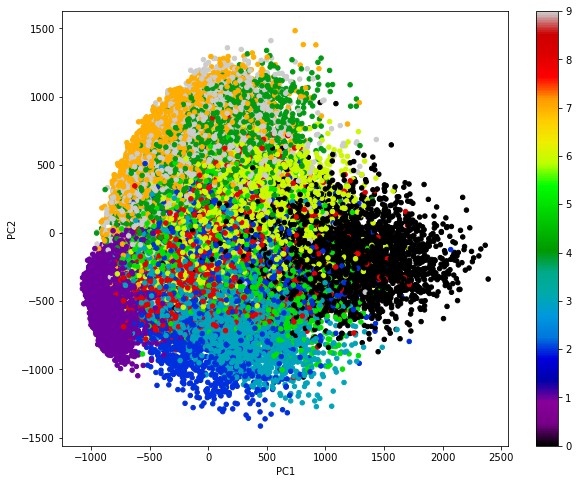

In [27]:
plt.figure(figsize=(10, 8))
plt.scatter(d_2[:,0],d_2[:,1], s=20, c = data['label'], cmap = "nipy_spectral")
plt.colorbar()

plt.xlabel("PC1")
plt.ylabel("PC2")